In [120]:
import findspark
findspark.init()

from pyspark.ml.feature import Word2Vec
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext

from pyspark import SparkContext
from pyspark.streaming import StreamingContext #Import streaming context
from pyspark.sql import SparkSession

import spacy
from pyspark.sql import functions as F

from neon_demo.kmeans import KMeans
from neon_demo.neon import NeuralizedKMeans, neon
from neon_demo.utils import *

import numpy as np
import torch as tr

from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder\
    .master('local[*]')\
    .appName('explore')\
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/30 18:55:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.json('/common/users/shared/cs543_fall22_group3/combined/deep_vectors')

In [5]:
df.show()

+--------------------+--------------------+
|       selected_text|              vector|
+--------------------+--------------------+
|Slippery slope to...|[0.08313738, 0.23...|
|Tori Spelling has...|[0.39983568, -0.1...|
|Northampton's tra...|[0.15577807, 0.10...|
|Making the best o...|[-0.05317878, 0.0...|
|Macy’s and Martha...|[0.30899784, -0.1...|
|Wrapping up a dev...|[0.2104713, 0.010...|
|Buscemi, Roth, Ke...|[0.09059073, 0.73...|
|Regulators should...|[0.018547548, -0....|
|General Motors in...|[0.53129065, 0.11...|
|Overall pay will ...|[0.08773228, -0.1...|
|Positive manufact...|[-0.041040532, -0...|
|Bright Colours On...|[0.41958135, 0.37...|
|The outlook for j...|[-0.034698613, 0....|
|Daniel Murphy hit...|[-0.07288053, 0.0...|
|Join Us for Incre...|[0.34747642, -0.0...|
|The Moammar Gadha...|[1.0501901, 0.033...|
|Reflections on th...|[0.4187972, -0.18...|
|An article in New...|[0.11336635, -0.0...|
|Autograph seekers...|[-0.07266332, 0.4...|
|Two United Nation...|[0.1636395

In [7]:
sample = df.take(100000)

In [9]:
import pandas as pd

In [10]:
sample_df = pd.DataFrame(sample)

In [12]:
sample_df.columns = ['text', 'vectors']

In [13]:
sample_df.head()

,text,vectors
0,Slippery slope to black hole saved by performa...,"[0.08313738, 0.23493402, 0.50700295, 0.2051836..."
1,Tori Spelling has been hospitalized in the wak...,"[0.39983568, -0.11452885, 0.30119494, -0.25674..."
2,Northampton's training will get more intense n...,"[0.15577807, 0.10933679, -0.04289341, -0.38488..."
3,Making the best of a garden can add tens of th...,"[-0.05317878, 0.02647339, -0.1828431, -0.01261..."
4,Macy’s and Martha Stewart Living Omnimedia say...,"[0.30899784, -0.17704536, 0.16132194, -0.12491..."


In [14]:
sample_df.to_csv('./sample_df.csv')

In [15]:
vectors = sample_df['vectors']

In [41]:
sample_df['vectors'] = sample_df['vectors'].apply(lambda x: [np.double(elem) for elem in x])

In [42]:
X = tr.tensor(vectors)

In [23]:
X

tensor([[ 0.0831,  0.2349,  0.5070,  ...,  0.4717, -0.1180, -0.3262],
        [ 0.3998, -0.1145,  0.3012,  ..., -0.1917,  0.1215,  0.1482],
        [ 0.1558,  0.1093, -0.0429,  ...,  0.0361,  0.3079,  0.3586],
        ...,
        [ 0.5599, -0.3750,  0.0293,  ...,  0.9819,  0.3237,  0.4516],
        [ 0.0128,  0.3216, -0.5594,  ...,  0.0660,  0.1652, -0.3446],
        [ 0.0846,  0.0444,  0.1727,  ...,  0.0316,  0.0688,  0.2893]])

In [43]:
# random state for reproducibility
m = KMeans(n_clusters=10, random_state=77)
m.fit(X)

In [28]:
m.centroids.size()

torch.Size([10, 96])

In [112]:
Y = X[5000:6000]

In [113]:
Y

tensor([[ 0.1067,  0.1866,  0.4567,  ...,  0.4052,  0.3000,  0.1810],
        [ 0.8198, -0.0718,  0.0432,  ...,  0.8881,  0.4657,  0.8664],
        [ 0.8557, -0.2738, -0.2435,  ..., -0.2858,  0.3247,  0.1940],
        ...,
        [ 0.1242,  0.0157, -0.0561,  ...,  0.4869,  0.2712,  0.2462],
        [-0.0679,  0.0908,  0.1370,  ...,  0.1606,  0.0961,  0.3424],
        [ 0.2700, -0.3400, -0.2424,  ...,  0.1651,  0.0867,  0.3438]],
       dtype=torch.float64)

In [115]:
predictions = m.kmeans.predict(Y)
predictions

array([6, 3, 8, 2, 9, 5, 6, 6, 1, 7, 6, 2, 0, 0, 1, 0, 4, 4, 4, 9, 6, 7,
       5, 9, 7, 0, 4, 5, 8, 7, 3, 9, 7, 4, 9, 0, 9, 2, 0, 4, 1, 2, 6, 9,
       5, 5, 0, 0, 5, 4, 0, 9, 7, 9, 4, 0, 3, 3, 5, 6, 0, 7, 0, 0, 9, 0,
       1, 9, 0, 8, 0, 9, 0, 9, 6, 6, 1, 7, 6, 6, 9, 9, 2, 6, 7, 9, 0, 6,
       2, 4, 4, 9, 9, 9, 6, 0, 2, 8, 2, 0, 3, 8, 3, 6, 3, 2, 5, 7, 1, 4,
       0, 4, 0, 8, 9, 9, 6, 8, 9, 5, 8, 0, 4, 0, 2, 7, 7, 3, 0, 7, 8, 1,
       8, 7, 2, 5, 5, 9, 3, 3, 3, 6, 1, 1, 1, 2, 9, 0, 6, 7, 5, 8, 1, 8,
       7, 1, 3, 0, 0, 9, 7, 9, 0, 0, 4, 7, 0, 1, 9, 0, 7, 0, 6, 6, 8, 6,
       4, 6, 0, 6, 8, 9, 0, 4, 5, 9, 4, 0, 0, 1, 9, 7, 1, 9, 0, 0, 4, 7,
       0, 1, 4, 8, 2, 0, 9, 9, 7, 9, 0, 9, 2, 0, 0, 9, 6, 7, 8, 0, 0, 9,
       9, 9, 6, 5, 2, 4, 9, 5, 0, 0, 3, 0, 4, 0, 0, 2, 8, 5, 2, 0, 8, 8,
       4, 8, 4, 2, 5, 2, 4, 6, 1, 5, 9, 0, 0, 4, 1, 4, 9, 0, 1, 9, 9, 0,
       0, 4, 6, 4, 4, 5, 0, 8, 4, 6, 1, 9, 9, 7, 0, 9, 9, 5, 9, 4, 8, 8,
       6, 9, 6, 4, 6, 6, 6, 5, 0, 9, 8, 0, 3, 7, 9,

In [121]:
y['predictions'] = predictions

/tmp/ipykernel_3279508/1456255764.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = predictions


In [122]:
y.iloc[1].text

'Wild: Mikael Granlund’s injury prompts concern'

In [123]:
y.iloc[7].text

'NTSB says pilot error caused fatal 2011 East River helicopter crash'

In [124]:
y

,text,vectors,predictions
5000,* Official inquiry into Bankia debacle unlikely,"[0.10666936, 0.1866081, 0.45666704, 0.06759252...",6
5001,Wild: Mikael Granlund’s injury prompts concern,"[0.8198183, -0.07179782, 0.043240048, -0.30157...",3
5002,New Samsung smartwatch won’t need companion phone,"[0.85574895, -0.27378622, -0.24350382, -0.2624...",8
5003,Bryan & CS City Employees Receiving Year End B...,"[0.8336041, 0.07768314, -0.30605012, -0.371811...",2
5004,Donald Trump on Sunday night slammed outgoing ...,"[0.29986054, -0.04564052, 0.23773333, 0.185806...",9
...,...,...,...
5995,"Extra Space Storage, Inc. (NYSE:EXR) EVP James...","[-0.034403358, 0.018770244, 0.096902594, -0.11...",4
5996,Analysts expect Anixter International Inc. (NY...,"[0.028117785, 0.11384956, 0.23596261, -0.07784...",4
5997,Equities research analysts predict that TerraF...,"[0.12416065, 0.015731081, -0.05605691, -0.1298...",4
5998,Great Canadian Gaming Corp (TSE:GC) insider Ch...,"[-0.06789104, 0.090811215, 0.13704167, -0.1014...",4


In [125]:
stopwords = set(STOPWORDS)

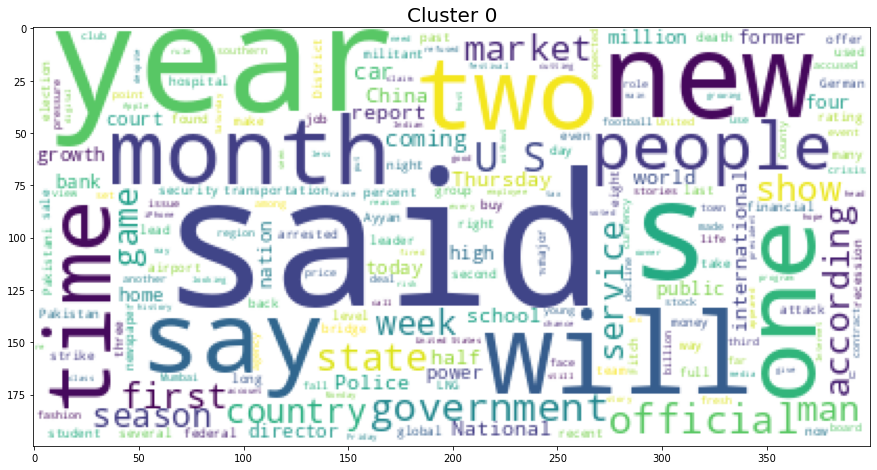

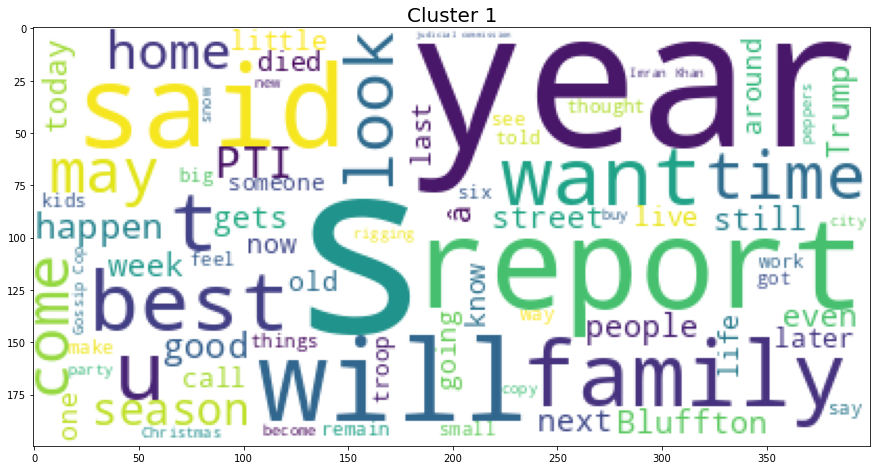

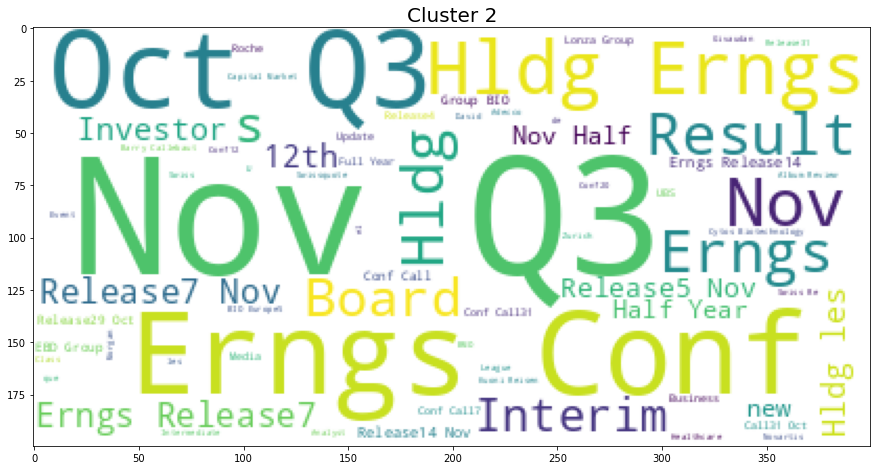

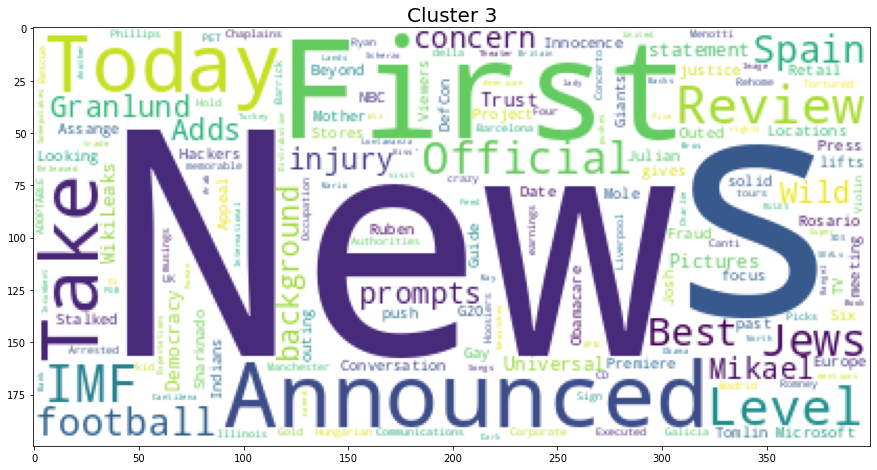

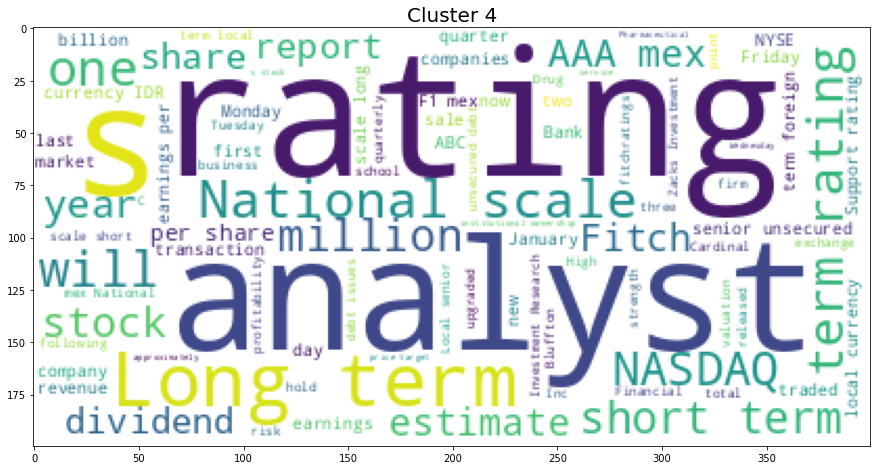

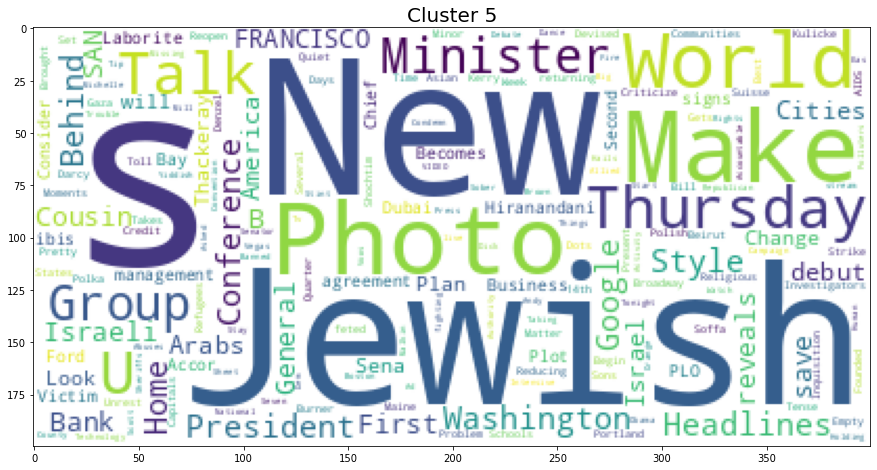

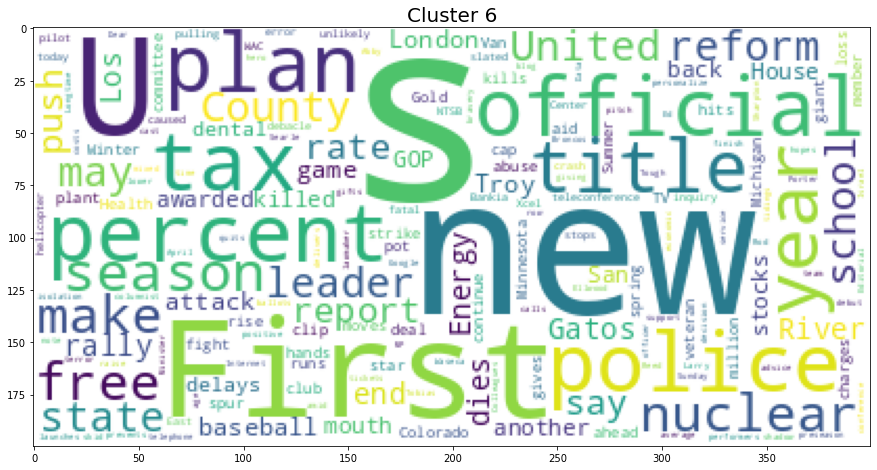

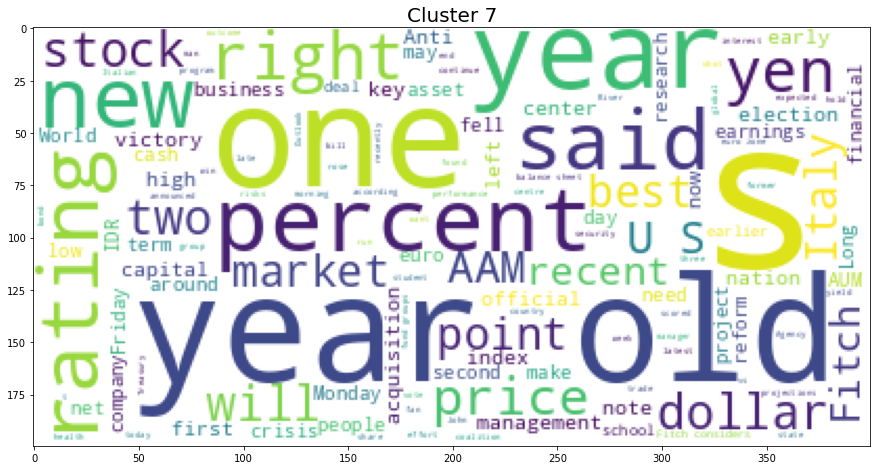

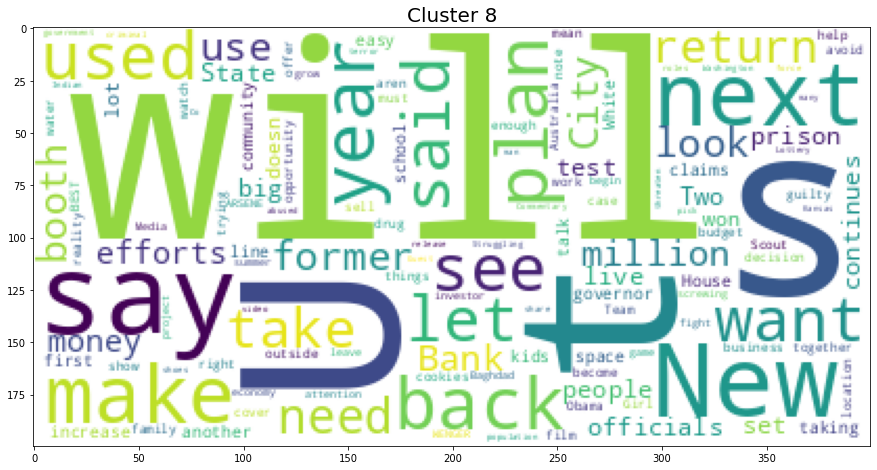

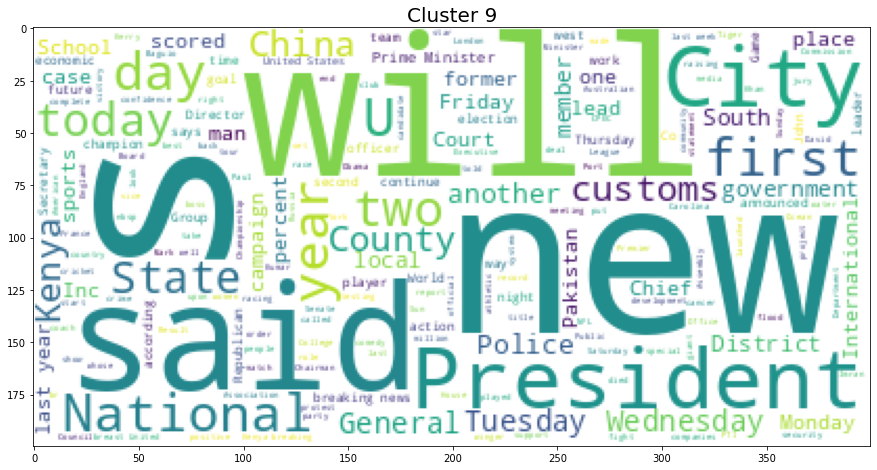

In [126]:
for i in range(10):
    cluster = y[predictions == i]
    
    if cluster.empty:
        continue

    cluster_text = ' '.join(i for i in cluster.text)
    wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(cluster_text)
    
    plt.figure(figsize=(15, 15))
    plt.title(f'Cluster {i}', fontsize=20)
    plt.imshow(wordcloud)
    plt.show()


In [ ]:
m = NeuralizedKMeans(m)